In [56]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as stats
import seaborn as sns

In [57]:
class SocialSpatialModel:
    def __init__(self, grid_size, subpopulations, n_infected, contact_rates, exposure_rate, recovery_rate, epsilon, baseline_activity_rate, income_values):
            self.m = grid_size
            self.N_k = np.array(subpopulations)
            self.I_0 = np.array(n_infected)
            self.A = np.array(contact_rates)  # This will be adjusted based on activity rates
            self.alpha = exposure_rate
            self.gamma = recovery_rate
            self.epsilon = epsilon
            self.baseline_activity_rate = baseline_activity_rate
            self.income_values = income_values
            self.Q = self.compute_vulnerability(income_values)  # update use logistic model
            self.A = self.compute_activity_rate()  # 3.7: update activity rate using the compute activity rate method. 
            self.B = self.compute_beta()
            

    def compute_beta(self):
        m2 = self.m**2
        B = np.zeros((m2, m2)) # initialize beta with zeros

        denominator = np.sum(self.A * self.N_k) # denominator of the beta formula
        indices_2d = [(i // self.m, i % self.m) for i in range(m2)] # change to 2d grid index, for checking neighbor

        # case 1: i and j are neighbors (up, down, left, right)
        for i in range(m2):
            for j in range(m2):
                if i != j:
                    diff = (abs(indices_2d[i][0] - indices_2d[j][0]), abs(indices_2d[i][1] - indices_2d[j][1]))
                    if diff in [(1, 0), (0, 1)]:  # check for up, down, left, right
                        B[i, j] = (1 - self.epsilon) * self.Q[i] * self.A[i] * self.A[j] / denominator
        # case 2: i = j, self transmission rate
        for i in range(m2):
            B[i, i] = (1 - self.epsilon) * self.Q[i] * self.A[i]**2 / denominator + self.epsilon * self.Q[i] * self.A[i] / self.N_k[i]

        return B
    
    def compute_vulnerability(self, income_levels):
        # vulnerability based on income levels
        logit_q = np.zeros_like(income_levels, dtype=float)
        for i, income in enumerate(income_levels):
            Z1 = 1 if 0.25 < income <= 0.50 else 0  # T1
            Z2 = 1 if income > 0.50 else 0  # T2
            logit_q[i] = -2 + Z1 + 2 * Z2
        
        # turn logit to probability
        q = 1 / (1 + np.exp(-logit_q))
        return q
    
    def compute_activity_rate(self):
        mul = np.random.uniform(0.8, 2, size = self.N_k.shape)
        # baseline_activity_rate = 12
        baseline_activity_rate = 8
        adjusted_activity_rate = baseline_activity_rate * mul
        return adjusted_activity_rate
    
    def get_initial_state(self):
        # need to return X where X = (S, E, I, R)
        S0 = self.N_k - self.I_0
        E0 = np.zeros_like(self.N_k)
        I0 = self.I_0
        R0 = np.zeros_like(self.N_k)
        return np.concatenate([S0, E0, I0, R0])  # N^2 * 4 # a vector

    def derivative(self, X, t):
        m2 = self.m**2
        S, E, I, R = X[:m2], X[m2:2*m2], X[2*m2:3*m2], X[3*m2:]

        dsdt = -self.B @ I * S
        dedt = self.B @ I * S - self.alpha * E
        didt = self.alpha * E - self.gamma * I
        drdt = self.gamma * I
        return np.concatenate([dsdt, dedt, didt, drdt])  # this should be a vector of length N^2 * 4

In [58]:
def initialize_model(grid_size, pop_grid, initial_infected, income_values, epsilon, exposure_rate, recovery_rate, contact_rates=None, baseline_activity_rate=12):
    pop = pop_grid.flatten()  
    n_infected = np.zeros_like(pop)
    
    # mark the initial infected cell
    n_infected[grid_size * initial_infected[0] + initial_infected[1]] = 1  
    
    if contact_rates is None:
        contact_rates = np.full(pop.shape, 1.0)
    
    model = SocialSpatialModel(grid_size=grid_size, 
                               subpopulations=pop - n_infected, 
                               n_infected=n_infected, 
                               contact_rates=contact_rates, 
                               exposure_rate=exposure_rate, 
                               recovery_rate=recovery_rate, 
                               epsilon=epsilon, 
                               baseline_activity_rate=baseline_activity_rate,  
                               income_values=income_values)
    return model

In [59]:
def run_simulation(model, days=30, dt=1.0):
    inf_record = np.zeros((model.m**2, int(days/dt)))
    X = model.get_initial_state().astype(np.float64)
    for day in range(int(days/dt)):
        dXdt = model.derivative(X, day * dt)
        X += dXdt * dt
        
        num = model.m ** 2
        S, E, I, R = X[:num], X[num:2*num], X[2*num:3*num], X[3*num:]
        inf_record[:, day] = I # update the record for each cell infectious number
    return I, inf_record 

def plot_infectious(infectious_record, days, dt=1.0):
    fig, axs = plt.subplots(3, 3, figsize=(15, 10))
    t = np.arange(0, days, dt)
    for i in range(3):
        for j in range(3):
            ax = axs[i, j]
            cell_index = i * 3 + j
            ax.plot(t, infectious_record[cell_index], label=f'({i+1}, {j+1})')
            ax.set_title(f'({i+1}, {j+1})')
            ax.set_xlabel('Days')
            ax.set_ylabel('Infectious Population')
            ax.legend()

            peak_day = np.argmax(infectious_record[cell_index])
            peak_value = infectious_record[cell_index][peak_day]

            ax.axvline(x=peak_day * dt, color='r', linestyle='--')
            ax.text(peak_day * dt, peak_value, f'Day {peak_day}', 
                    color='r', va='bottom', fontsize=12, fontweight='semibold')

    plt.tight_layout()
    plt.show()
    
    
def plot_SEIR(X, days, grid_size=3, dt=1.0):
    num_cells = grid_size ** 2
    t = np.arange(0, days, dt)
    fig, axs = plt.subplots(grid_size, grid_size, figsize=(15, 15))  # Adjust subplot grid as needed
    
    for cell in range(num_cells):
        i, j = divmod(cell, grid_size)
        S, E, I, R = X[cell], X[cell + num_cells], X[cell + 2*num_cells], X[cell + 3*num_cells]
        
        ax = axs[i, j]
        ax.plot(t, S, label='Susceptible')
        ax.plot(t, E, label='Exposed')
        ax.plot(t, I, label='Infectious')
        ax.plot(t, R, label='Recovered')
        
        ax.set_title(f'Cell {i+1}, {j+1}')
        ax.set_xlabel('Days')
        ax.set_ylabel('Population')
        ax.legend()
    
    plt.tight_layout()
    plt.show()
    
def plot_final_heatmap(model, grid_infection):
    infected_pop = grid_infection.reshape(model.m, model.m)

    fig, ax = plt.subplots(figsize=(8, 6))
    cax = ax.imshow(infected_pop, cmap='viridis', interpolation='nearest')

    for i in range(infected_pop.shape[0]):
        for j in range(infected_pop.shape[1]):
            text = ax.text(j, i, f'{infected_pop[i, j]:.4f}', ha="center", va="center", color="w", fontsize=12)

    plt.colorbar(cax, label='Infected Population')
    plt.title('Infected Population Heatmap after n Days')
    plt.xlabel('Cell X Coordinate')
    plt.ylabel('Cell Y Coordinate')
    plt.show()

## Experiment 1: Segregated Map

set $\epsilon = 0.9$ to see what will happen?

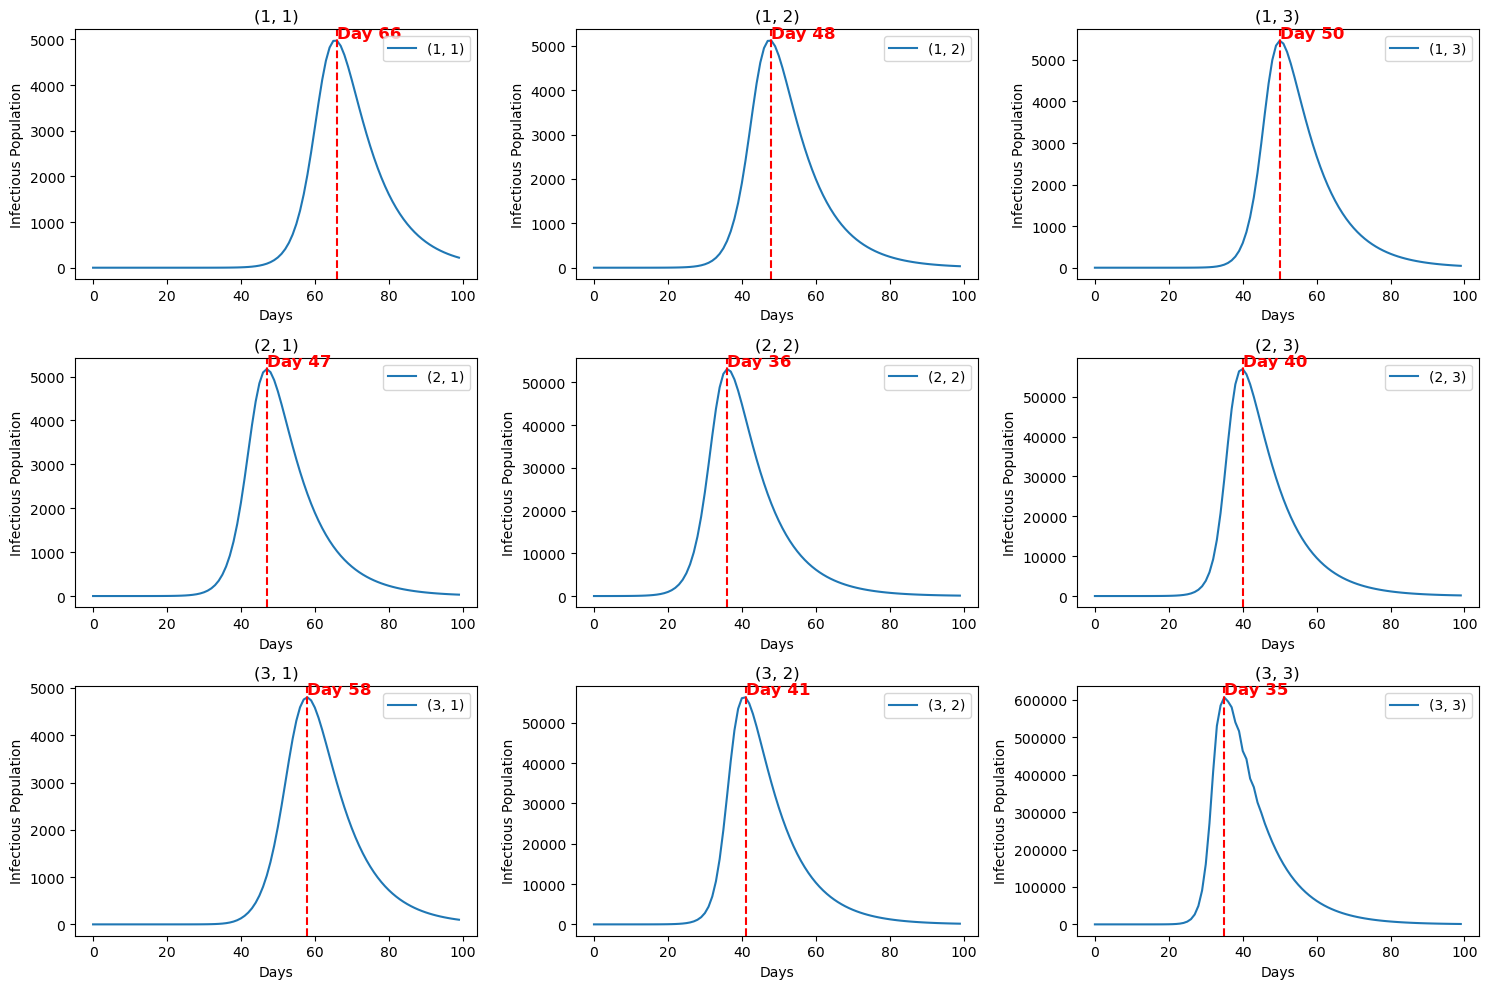

In [60]:
grid_size = 3
pop_grid = np.array([[10000, 10000, 10000], 
                     [10000, 100000, 100000], 
                     [10000, 100000, 1000000]])
initial_infected = (1, 1) 
income_values = np.array([0.1, 0.1, 0.1, 
                          0.1, 0.2, 0.2, 
                          0.1, 0.2, 0.3]) # CONSIDER CHNAGE TO 0.2, 0.1, 0.05

epsilon = 0.9  


exposure_rate = 0.3
recovery_rate = 0.1
number_of_days = 100


# Initialize the model
model = initialize_model(grid_size, pop_grid, initial_infected, income_values, epsilon, exposure_rate, recovery_rate)

# Run the simulation
grid_infection, inf_record_case1 = run_simulation(model, days=number_of_days, dt=1.0)
plot_infectious(inf_record_case1, number_of_days)

## Experiment 2

set $\epsilon =0.1$, and set $q$ uniformly. How do cell population and activity rate affect the spread over space (start with 1 infected cell). 

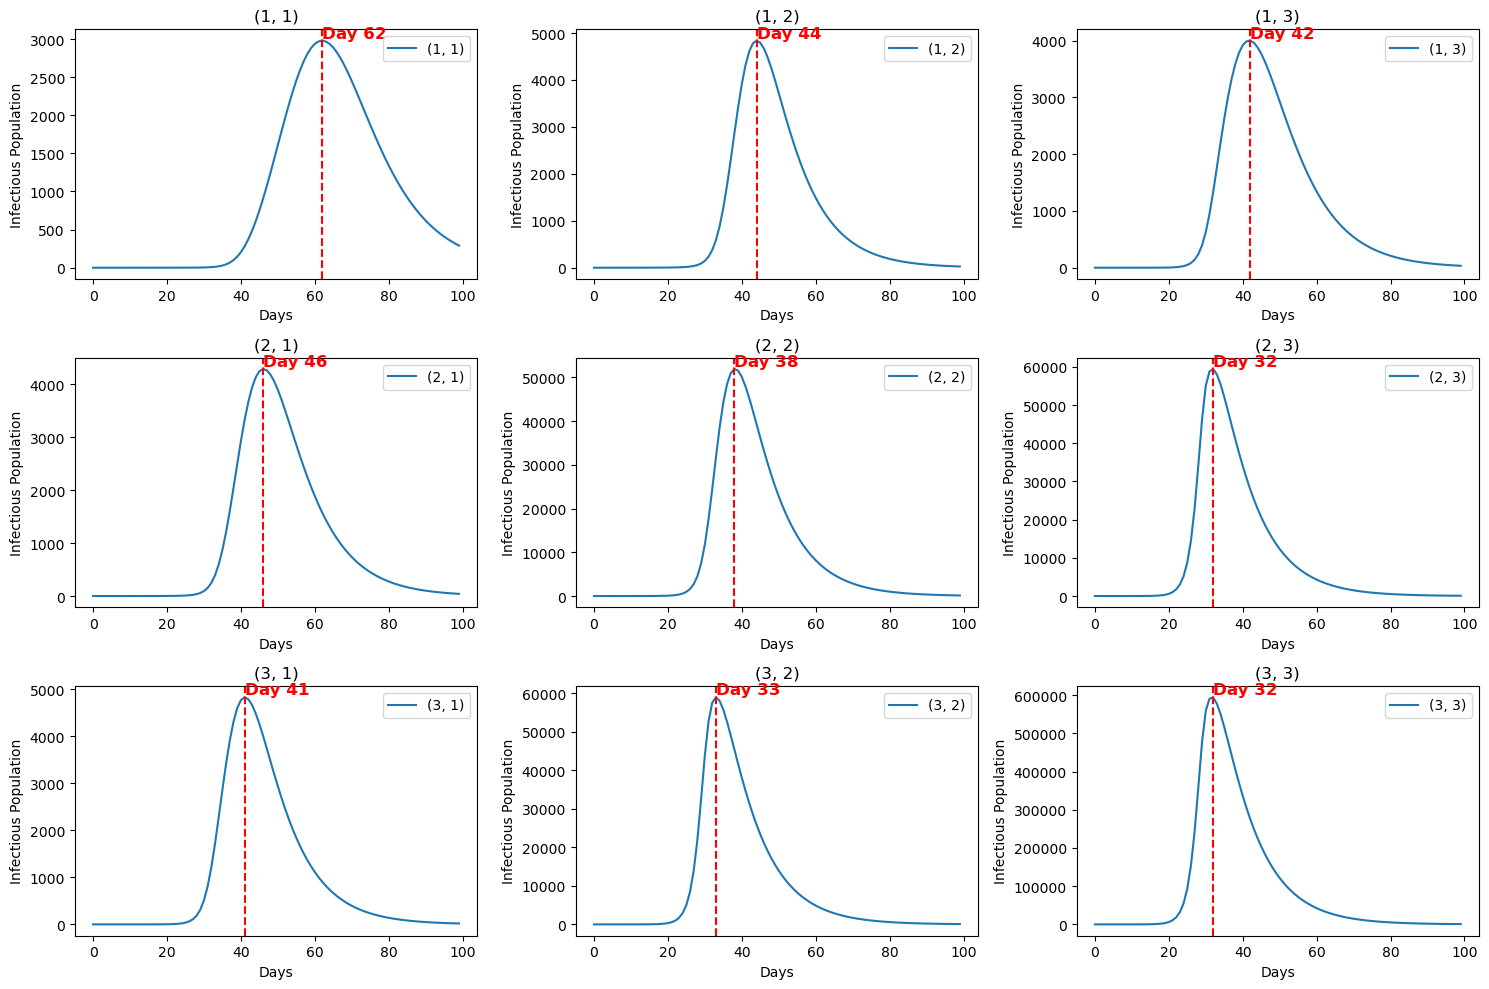

In [61]:
epsilon_case2 = 0.1 

uniform_income_value = 0.5
income_values_uniform_q = np.full((grid_size**2,), uniform_income_value)


grid_size = 3
pop_grid = np.array([[10000, 10000, 10000], 
                     [10000, 100000, 100000], 
                     [10000, 100000, 1000000]])
initial_infected = (1, 1) 
 
exposure_rate = 0.3
recovery_rate = 0.1
number_of_days = 100

# initialize the model for CASE 2
model_case2 = initialize_model(grid_size, pop_grid, initial_infected, 
                               income_values_uniform_q, epsilon_case2, 
                               exposure_rate, recovery_rate)

grid_infection_case2, inf_record_case2 = run_simulation(model_case2, days=number_of_days, dt=1.0)
plot_infectious(inf_record_case2, number_of_days)

## Experiment 3

1. Variability in $q$ (H, M, L)
2. Small $\epsilon$: spatial dependencies.

Does intermobility increase or decrease inequality in outcomes?

Two Sections:
1. array[[H, M, L], [M, L, H], [L, H, M]], this is "inequality at random", no spatial / geographic structure to $q$
2. array[[L, L, L], [L, M, M], [L, M, H]], this is "segregation"

## Experiment 4

1. The first scenario has a homogeneous distribution where every cell has the same $q_i$ equal to the global average (0.1)
2. The second scenario is highly hetergeneous, with some cells having $q_i$ close to zero, and other are higher than global average, while still having the same average $q$ across the grid. 

In [62]:
grid_size = 3
pop_grid = np.full((grid_size, grid_size), 10000)  
initial_infected = (1, 1)
epsilon = 0.1
exposure_rate = 0.3
recovery_rate = 0.1
number_of_days = 100

average_q = 0.1
homogeneous_q = np.full((grid_size**2,), average_q)
model_homogeneous = initialize_model(grid_size, pop_grid, initial_infected, 
                                     homogeneous_q, epsilon, 
                                     exposure_rate, recovery_rate)
_, inf_record_homogeneous = run_simulation(model_homogeneous, days=number_of_days, dt=1.0)

heterogeneous_q = np.array([0.005, 0.005, 0.005, 0.005, 0.25, 0.25, 0.005, 0.25, 0.25])
print(np.mean(heterogeneous_q))

0.11388888888888887


Homogeneous Case:


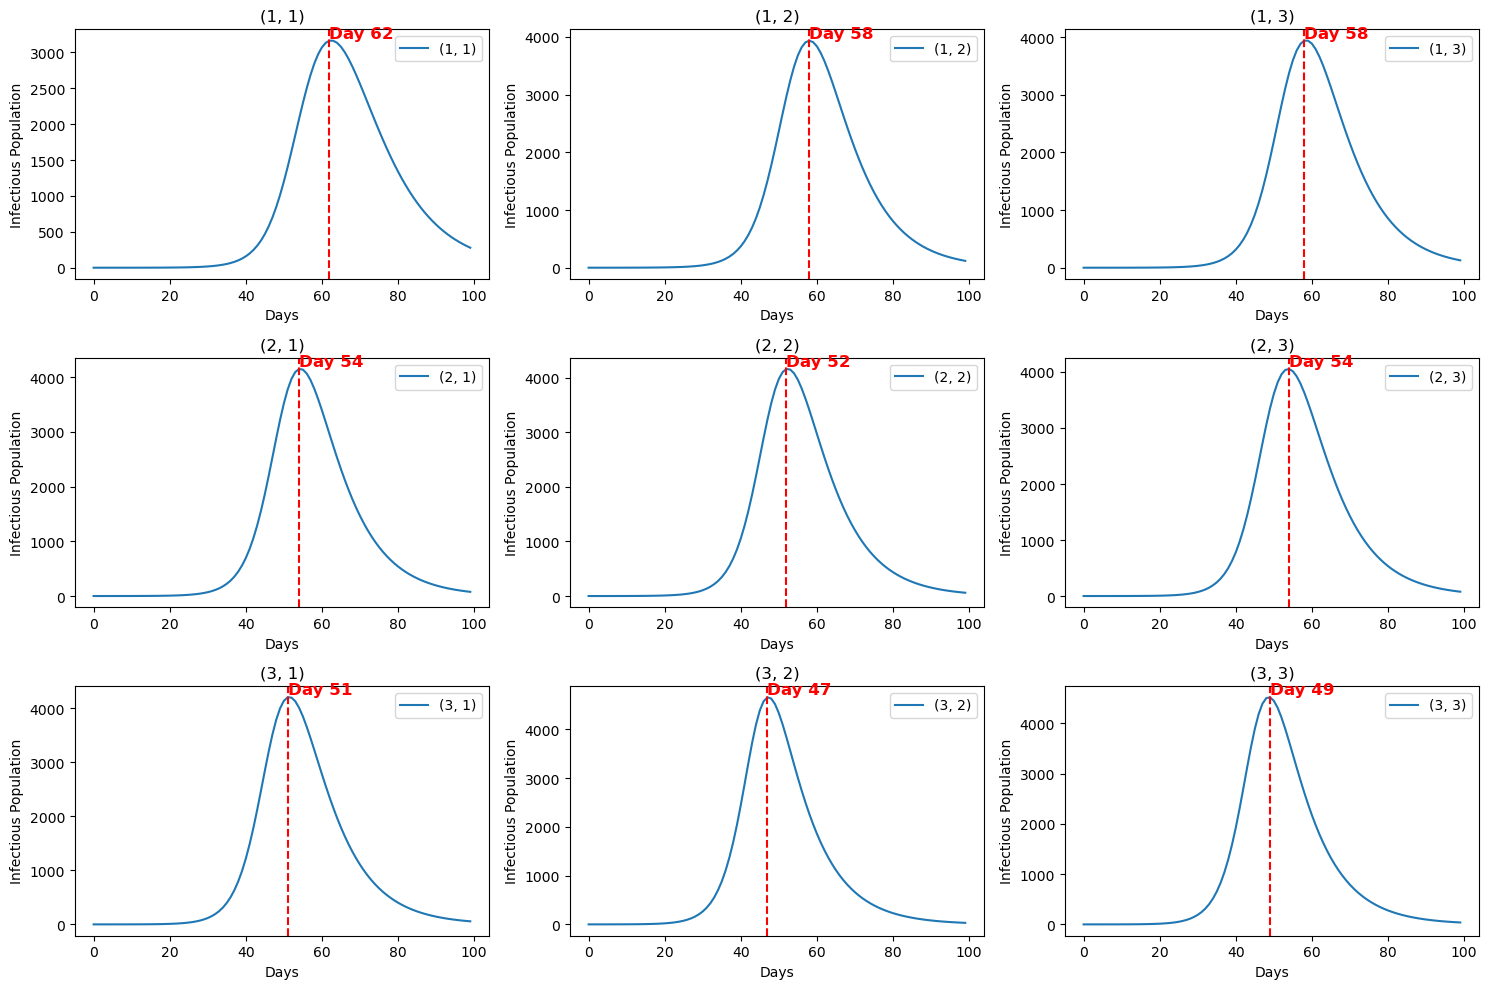

Heterogeneous Case:


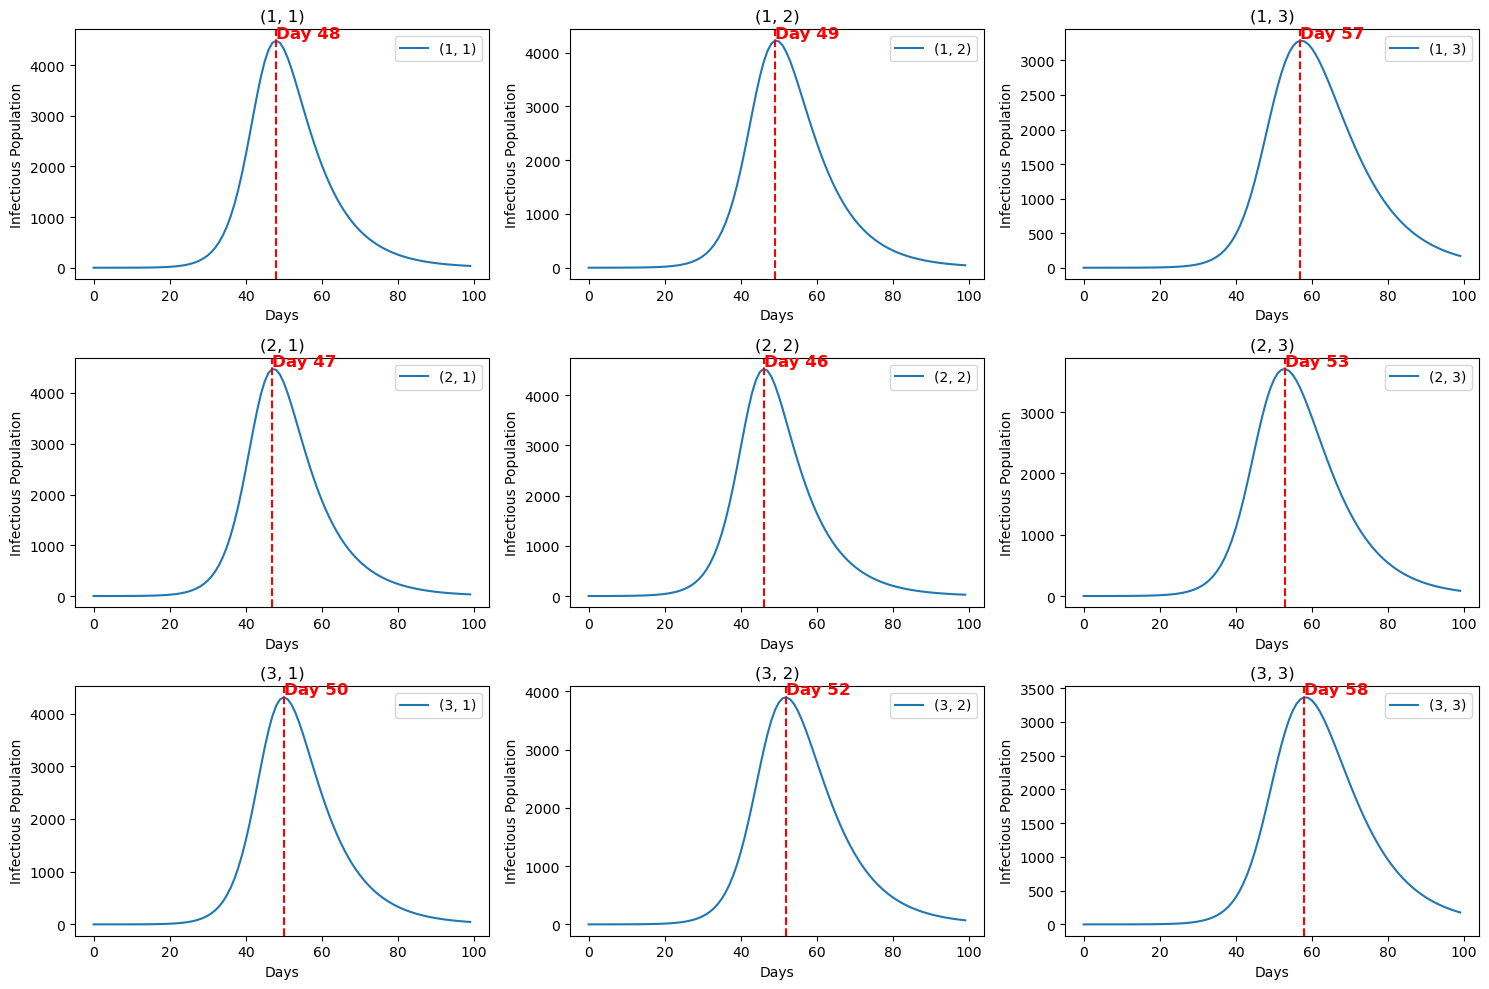

In [63]:
model_heterogeneous = initialize_model(grid_size, pop_grid, initial_infected, 
                                       heterogeneous_q, epsilon, 
                                       exposure_rate, recovery_rate)
_, inf_record_heterogeneous = run_simulation(model_heterogeneous, days=number_of_days, dt=1.0)


print("Homogeneous Case:")
plot_infectious(inf_record_homogeneous, number_of_days)
print("Heterogeneous Case:")
plot_infectious(inf_record_heterogeneous, number_of_days)

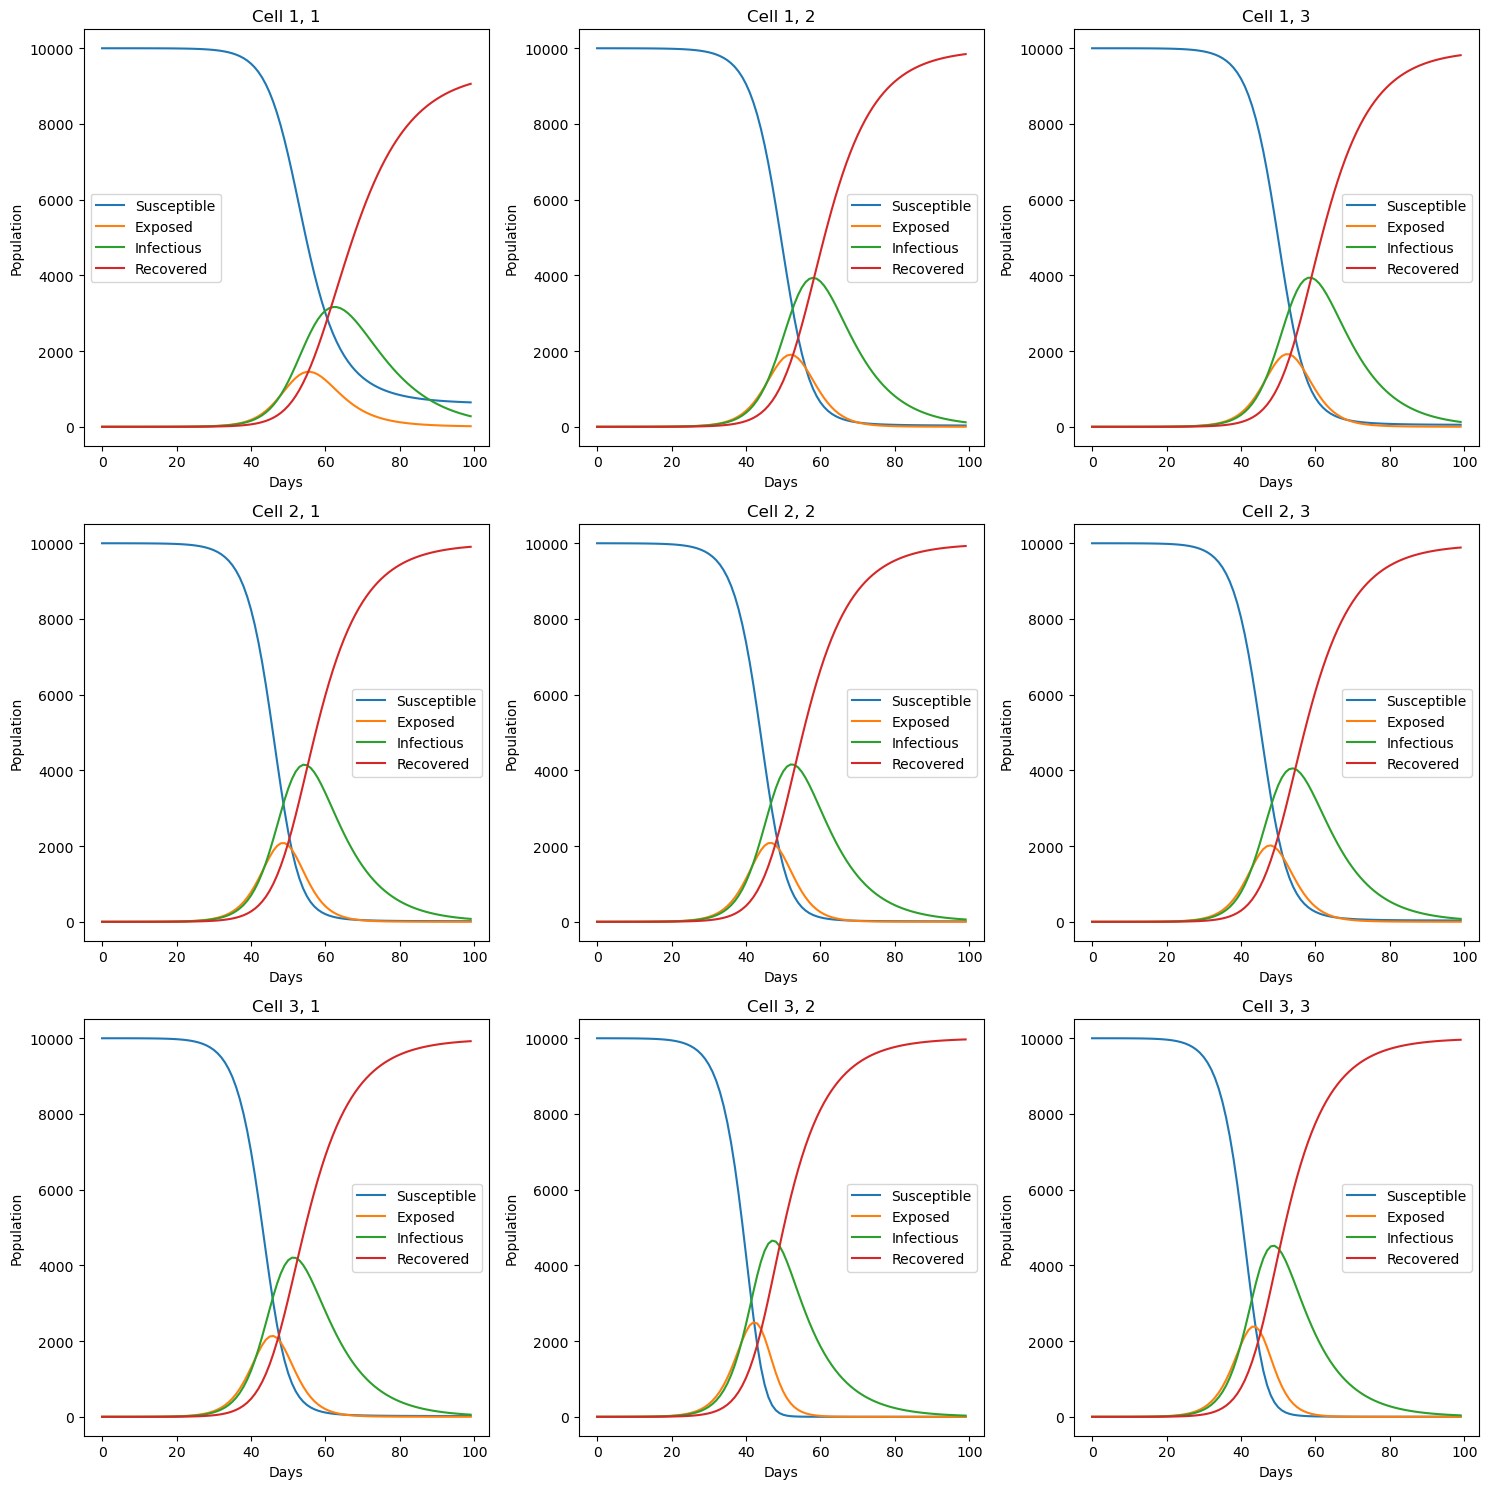

In [64]:
def run_simulation_full(model, days=30, dt=1.0):
    m2 = model.m ** 2
    X = model.get_initial_state().astype(np.float64)
    history = np.zeros((m2 * 4, int(days/dt)))  # Storing full history
    
    for day in range(int(days/dt)):
        dXdt = model.derivative(X, day * dt)
        X += dXdt * dt
        history[:, day] = X  # Store the state at this timestep
    
    return history
full_history = run_simulation_full(model_homogeneous, days=number_of_days, dt=1.0)
plot_SEIR(full_history, number_of_days, grid_size=grid_size)

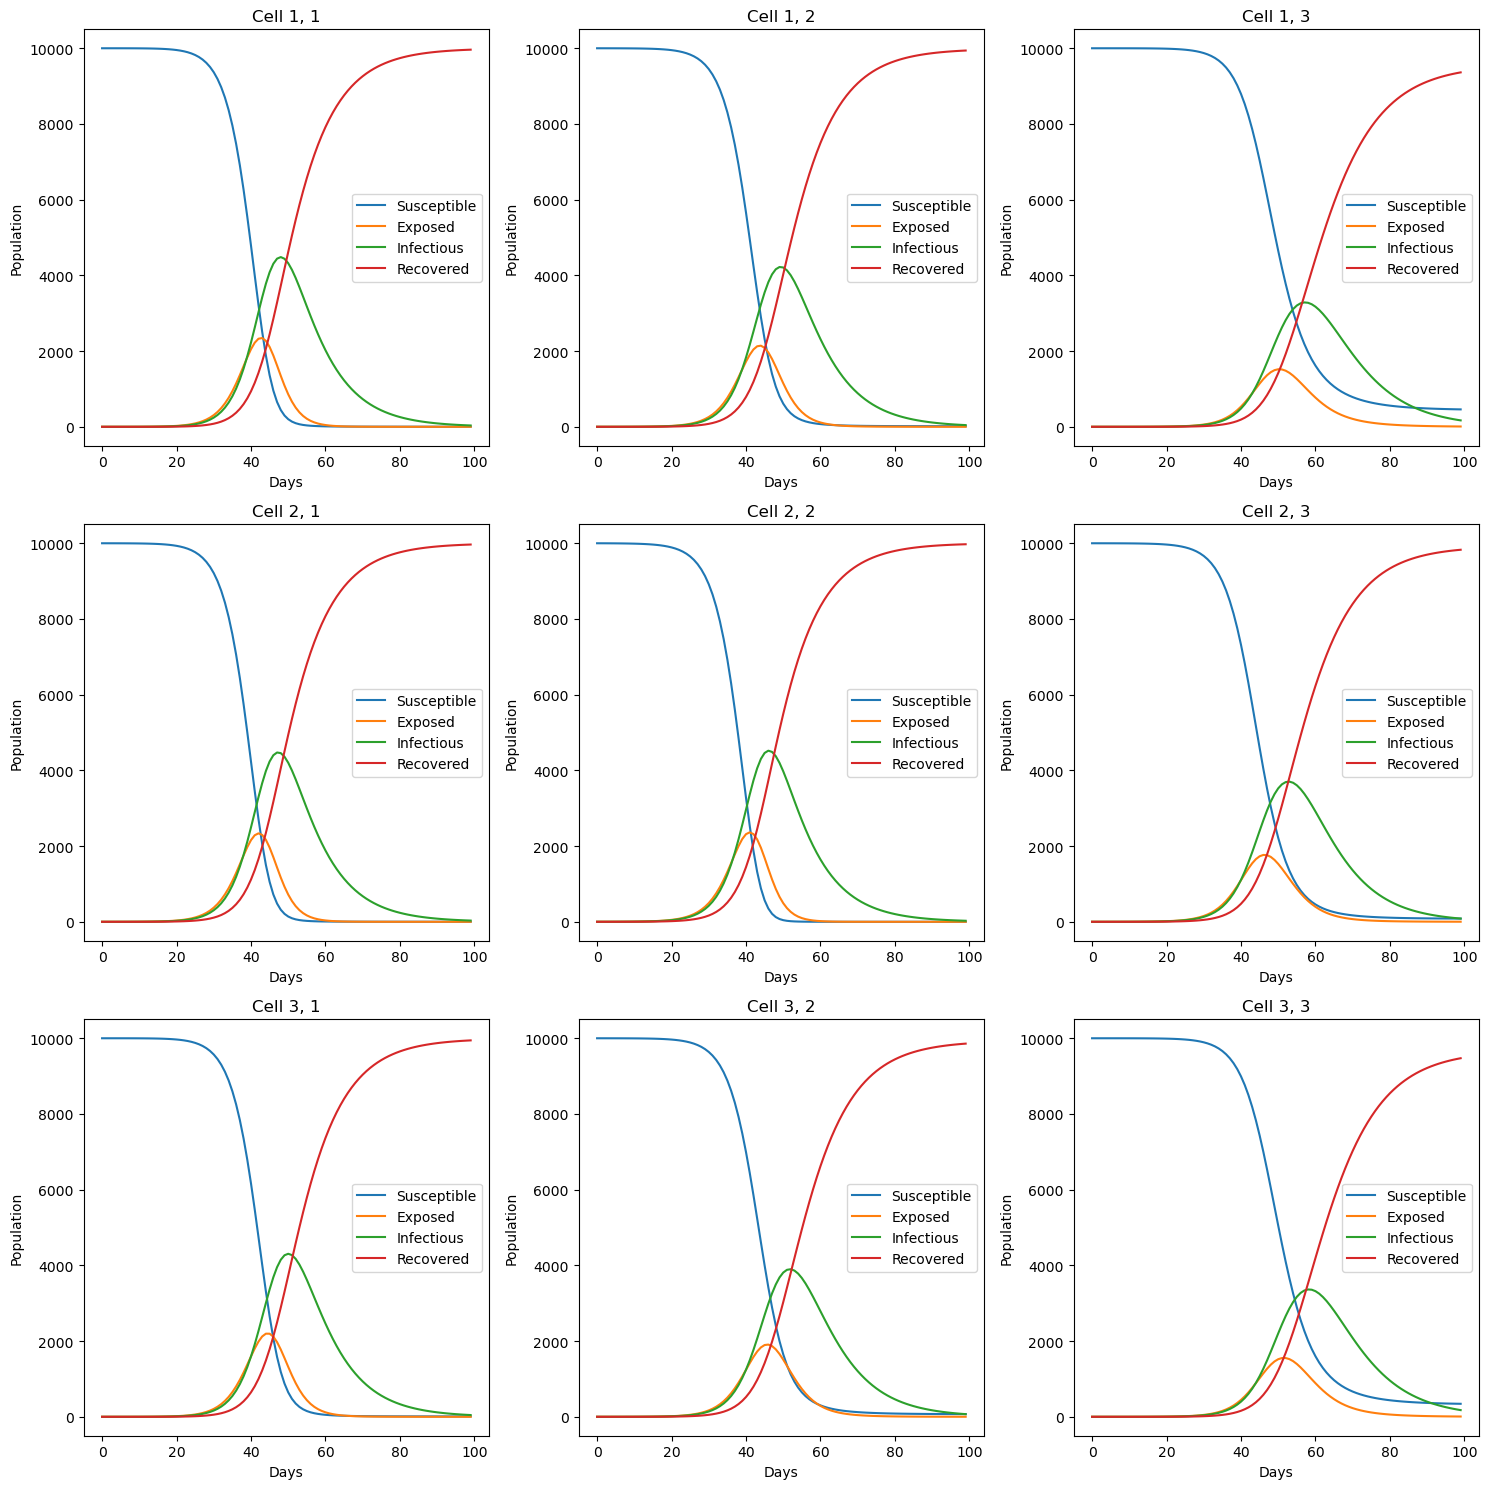

In [65]:
full_history = run_simulation_full(model_heterogeneous, days=number_of_days, dt=1.0)
plot_SEIR(full_history, number_of_days, grid_size=grid_size)